In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import seaborn as sns
import glob as glob
import os
import gc
import pylandstats as pls
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
from shapely.geometry.polygon import Polygon
import plotly.express as px

np.random.seed(0)

### 1. Load Geospatial

In [2]:
# Read
struc = gpd.read_file("data/Structure.gpkg")
veg = gpd.read_file("data/VegType.gpkg")


In [3]:
veg['landcover_highest'] = veg['landcover_highest'].replace(to_replace={'Tall forbs':'Tall-growing forbs', 'Low forbs':'Low-growing forbs', 'Trees':'Conifer seedlings'})

struc['site_2'] = struc.loc[:,'site']
veg['site_2'] = veg.loc[:,'site']

struc['site'] = struc['site'].replace({'Wildfire Chinchaga A':'Wildfires Chinchaga', 'Wildfire Chinchaga B':'Wildfires Chinchaga'})
veg['site'] = veg['site'].replace({'Wildfire Chinchaga A':'Wildfires Chinchaga', 'Wildfire Chinchaga B':'Wildfires Chinchaga'})

struc['dataset_cluster_alpha'] = struc['dataset_cluster_alpha'].replace({'Wildfire Chinchaga A':'A Wildfires Chinchaga', 'Wildfire Chinchaga B':'B Wildfires Chinchaga'}, regex=True)
veg['dataset_cluster_alpha'] = veg['dataset_cluster_alpha'].replace({'Wildfire Chinchaga A':'A Wildfires Chinchaga', 'Wildfire Chinchaga B':'B Wildfires Chinchaga'}, regex=True)

struc["Class"] = struc["Class"].replace({1.0:'Tall and complex', 
                        2.0:'Mid-tall and moderate complexity', 
                        3.0:'Short and moderate complexity', 
                        4.0:'No structures and no complexity',
                        5.0:'No structures and minimal complexity', 
                        6.0:'Very short and no complexity', 
                        7.0:'Vegetation > 2m'})

### 2. Load and Modify Field Data

In [4]:

# Read original field data 
df = pd.read_excel("data/in/Rik's Field Data Modified Check2.xlsx") 
df_attributes = pd.read_csv("data/in/Lookup_genus_and_type.csv") # Lookup table


In [5]:
# Edits
df = df.loc[:, ['Site.Name', 'Transect', 'Grid', 'Cover', 'Species_corrected_unique', 'Species_latin', 'Feature']] # Keep only relevant columns and rows
df['Site.Name'] = df['Site.Name'].replace({'GC2006':'Wildfire Little Smoky', 'MN 2018':'Wildfire Chinchaga A', 'MN 2019':'Wildfire Chinchaga B',
                         'CHIN_2009_A':'ROW Chinchaga A', 'CHIN_2014_B':'ROW Chinchaga B', 'GC_2005_C':'ROW Little Smoky'}) # Rename sites
df = df.loc[df['Site.Name']!='Invasives']
df['QuadratID'] = df['Site.Name'].astype(str) + '_' + df['Transect'].astype(str) + '_' + df['Grid'].astype(str) # Create Quadrat FID column

# Corrections
df['Cover'] = np.where(df['Cover']=='<5', 4, df['Cover']) # replace cover '<5' with 4
df['Cover'] = np.where(df['Cover'].isna(), 3, df['Cover']) # replace cover 'nan' with 3

# Join attributes
df = pd.merge(df, df_attributes, how='left', on='Species_latin')
df['Plant func type'] = np.where(df['Feature']=='Bare', 'Bare soil', df['Plant func type'])
df['Native in Alberta'] = np.where(df['Feature']=='Bare', 'Yes', df['Native in Alberta'])

# QuadratID as index
df.set_index('QuadratID', inplace=True)

### CORRECT COVER PERCENTAGES
# 1. DataFrame with SUM of cover percentages by Quadrat
sumSeries = df.groupby('QuadratID')['Cover'].sum().rename("Total_quadrat_cover")

# 2. Add to initial DataFrame
df = pd.merge(df, sumSeries, how='left', left_index=True, right_index=True, suffixes=('', ''))

# 3. Drop nans
df = df.loc[~df['Plant func type'].isna()]
# 4. Drop more
df = df.loc[df["Plant func type"]!="Other"]


# Replace values where needed
df['Plant func type'] = df['Plant func type'].replace({'Shurb':'Shrubs', 'Shrubss':'Shrubs', 'Trees':'Conifer seedlings'})

# 5. Create a new column with cover percentages corrected to 100 percent
df['Cover_corrected'] =  df['Cover'] / df["Total_quadrat_cover"] * 100 

# 6. Reset index, this is necessary for pivotting
df.reset_index(inplace=True)


# Some more edits...

# 1. All mosses should become one single "species" and be set to "Native in Alberta"=="Yes"
renamer = {'Mosses Spp.':'Bryophytes', 'Sphagnaceae Spp.':'Bryophytes', 'Liverworts Spp.':'Bryophytes','Polytrichum commune':'Bryophytes'}
df['Species_latin'] = df['Species_latin'].replace(renamer) # REplace names
df['Native in Alberta'] = df['Native in Alberta'].fillna('Yes') # Replace nan

# 2. Rename wildfire sites Chincahga
df['Site'] = df.loc[:,"Site.Name"]
df['Site'] = df['Site'].replace({'Wildfire Chinchaga A':'Wildfires Chinchaga', 'Wildfire Chinchaga B':"Wildfires Chinchaga"})

# 3. New transect ID column
df['TransectID'] = df['Site'] + '_' + df['Transect'].astype(str)


### 3. Cover percentages by plant functional types
#### ...from field data

In [6]:
df_func_types_a = df.groupby(['Site.Name','Plant func type'], as_index=False)['Cover_corrected'].sum()
cover_perc_site_totals = df_func_types_a.groupby(['Site.Name'], as_index=False)['Cover_corrected'].sum().rename(columns={'Cover_corrected':'Total'})

df_func_types_a = pd.merge(df_func_types_a,cover_perc_site_totals, how='left')
df_func_types_a['Cover'] = df_func_types_a['Cover_corrected']  / df_func_types_a['Total'] * 100

df_func_types_a = df_func_types_a.rename(columns={'Site.Name':'Site', 'Plant func type':'Plant Functional Type'})
df_func_types_a = df_func_types_a.loc[:,['Site', 'Plant Functional Type', 'Cover']]

df_func_types_a.head()

,Site,Plant Functional Type,Cover
0,ROW Chinchaga A,Bare soil,4.627417
1,ROW Chinchaga A,Bryophytes,4.497067
2,ROW Chinchaga A,Conifer seedlings,1.759722
3,ROW Chinchaga A,Grasses,38.477080
4,ROW Chinchaga A,Low-growing forbs,13.647621


#### ...from drone maps

In [7]:
df_func_types_b = veg.groupby(['site_2','landcover_highest'], as_index=False)['ID'].count()
cover_perc_site_totals = veg.groupby(['site_2'], as_index=False)['ID'].count().rename(columns={'ID':'Total'})

df_func_types_b = pd.merge(df_func_types_b,cover_perc_site_totals, how='left', on='site_2')
df_func_types_b['Cover'] = df_func_types_b['ID']  / df_func_types_b['Total'] * 100

df_func_types_b = df_func_types_b.rename(columns={'site_2':'Site', 'landcover_highest':'Plant Functional Type'})
df_func_types_b = df_func_types_b.loc[:,['Site', 'Plant Functional Type', 'Cover']]

df_func_types_b.head()

,Site,Plant Functional Type,Cover
0,ROW Chinchaga A,Bare soil,1.229723
1,ROW Chinchaga A,Bryophytes,10.465725
2,ROW Chinchaga A,Conifer seedlings,17.268446
3,ROW Chinchaga A,Grasses,28.597593
4,ROW Chinchaga A,Low-growing forbs,11.721612


#### ...combine

In [8]:
df_func_types_a['Dataset'] = 'Field-based samples'
df_func_types_b['Dataset'] = 'Drone-based maps'

# Merge
df_func_types = pd.concat([df_func_types_a, df_func_types_b])

# Reorder
df_func_types["Dataset"] = pd.Categorical(df_func_types["Dataset"], categories=['Drone-based maps', 'Field-based samples'], ordered=True)
df_func_types["Plant Functional Type"] = pd.Categorical(df_func_types["Plant Functional Type"], categories=['Bryophytes', 'Conifer seedlings', 'Grasses',
                                                                                                            'Low-growing forbs', 'Shrubs', 'Tall-growing forbs',
                                                                                                            'Bare soil'], ordered=True)
df_func_types = df_func_types.sort_values(by=["Plant Functional Type","Dataset"])

# Show
df_func_types.head()

,Site,Plant Functional Type,Cover,Dataset
1,ROW Chinchaga A,Bryophytes,10.465725,Drone-based maps
8,ROW Chinchaga B,Bryophytes,5.476485,Drone-based maps
15,ROW Little Smoky,Bryophytes,49.756463,Drone-based maps
22,Wildfire Chinchaga A,Bryophytes,8.982585,Drone-based maps
29,Wildfire Chinchaga B,Bryophytes,11.652478,Drone-based maps


### 3b. Cover percentages by structure type

In [9]:
df_structure = struc.groupby(['site_2','Class'], as_index=False)['ID'].count()
df_structure_totals = struc.groupby(['site_2'], as_index=False)['ID'].count().rename(columns={'ID':'Total'})

df_structure = pd.merge(df_structure, df_structure_totals, how='left', on='site_2')
df_structure['Cover'] = df_structure['ID']  / df_structure['Total'] * 100

df_structure = df_structure.rename(columns={'site_2':'Site', 'Class':'Structure Type'})
df_structure = df_structure.loc[:,['Site', 'Structure Type', 'Cover']]

# Sort
df_structure["Structure Type"] = pd.Categorical(df_structure["Structure Type"], ['Tall and complex', 'Mid-tall and moderate complexity', 
                                                 'Short and moderate complexity', 'No structures and no complexity',
                                                 'No structures and minimal complexity', 
                                                 'Very short and no complexity', 'Vegetation > 2m'])
df_structure = df_structure.sort_values(by='Structure Type')


### 4. Calculate SIMPER
#### ...from drone maps

In [10]:
from source_code.simper import simper

# Function to create abundance matrix (relative counts) from polygon dataset
def abundance_matrix(df, column_class, column_plot):
    
    df = df.groupby(column_plot, as_index=False)[column_class].value_counts()
    df = df.pivot(index=column_plot, columns=column_class)
    df.columns = df.columns.get_level_values(1)  
    df = df.rename_axis(None, axis=0).rename_axis(None, axis=1)
    
    # Convert to percentages
    df['Total'] = df.sum(axis=1)
    plant_columns = df.columns[:-1]  # Exclude 'Total' column

    for plant_column in plant_columns:
        df[plant_column] = (df[plant_column] / df['Total']) * 100       
    df.drop(columns='Total', inplace=True)   
    return(df.round(decimals=1))

# -----------------------------------------------------------------
# --------------VEGETATION TYPES-----------------------------------
# -----------------------------------------------------------------

# Get abudance data table for using site segments and plant types (from polygons)
simper_df = abundance_matrix(df=veg, column_class='landcover_highest', column_plot='dataset_cluster_alpha').fillna(0.01, inplace=False).replace(0, 0.01)
site_labels = [i.split('_')[0].removeprefix("A ").removeprefix("B ") for i in simper_df.index] # Derive site names

# Calculate SIMPER values
simper_df = simper(data=simper_df, factor=site_labels, spNames=None) # Calculate
simper_df = simper_df.reset_index().rename(columns={'level_0':'Site', 'level_1':'Plant Functional Type', 'sp_pct':'SIMPER'}) # Modify
# simper_df['Dataset'] = 'Drone-based maps' # Modify
simper_df['SIMPER'] = simper_df['SIMPER'].round(decimals=0).astype(int)

# Keep only relevant site combinations
simper_df = simper_df.loc[simper_df['Site'].isin(['ROW Chinchaga A-Wildfires Chinchaga',
                'ROW Chinchaga B-Wildfires Chinchaga',
                'ROW Little Smoky-Wildfire Little Smoky'])]

# Rename site pairs to keep only ROW names
simper_df['Site'] = simper_df['Site'].str.split('-', expand=True)[0]

# Keep only relevant columns
simper_df = simper_df.loc[:,['Site', 'Plant Functional Type', 'SIMPER']]

# Join on table with cover percentages
df_func_types['Site_join'] = df_func_types['Site'].replace(to_replace={'Wildfire Chinchaga A': 'ROW Chinchaga A',
                                                                           'Wildfire Chinchaga B': 'ROW Chinchaga B',
                                                                           'Wildfire Little Smoky': 'ROW Little Smoky'})
df_func_types = pd.merge(df_func_types, simper_df, how='left', left_on=['Site_join', 'Plant Functional Type'],
                         right_on=['Site', 'Plant Functional Type']).rename(columns={'Site_x':'Site'}).drop(columns='Site_y')

# Create 'Plant Func Type' + SIMPER value column
df_func_types['Plant Functional Type (SIMPER)'] = df_func_types['Plant Functional Type'] + ' (' + df_func_types['SIMPER'].astype(str) + '%)'



# -----------------------------------------------------------------
# --------------STRUCTURE TYPES------------------------------------
# -----------------------------------------------------------------

# Get abudance data table for using site segments and plant types (from polygons)
simper_df = abundance_matrix(df=struc, column_class='Class', column_plot='dataset_cluster_alpha').fillna(0.01, inplace=False).replace(0, 0.01)
site_labels = [i.split('_')[0].removeprefix("A ").removeprefix("B ") for i in simper_df.index] # Derive site names

# Calculate SIMPER values
simper_df = simper(data=simper_df, factor=site_labels, spNames=None) # Calculate

simper_df = simper_df.reset_index().rename(columns={'level_0':'Site', 'level_1':'Structure Type', 'sp_pct':'SIMPER'}) # Modify
simper_df['SIMPER'] = simper_df['SIMPER'].round(decimals=0).astype(int)

# Keep only relevant site combinations
simper_df = simper_df.loc[simper_df['Site'].isin(['ROW Chinchaga A-Wildfires Chinchaga',
                'ROW Chinchaga B-Wildfires Chinchaga',
                'ROW Little Smoky-Wildfire Little Smoky'])]

# Rename site pairs to keep only ROW names
simper_df['Site'] = simper_df['Site'].str.split('-', expand=True)[0]

# Keep only relevant columns
simper_df = simper_df.loc[:,['Site', 'Structure Type', 'SIMPER']]

# Join on table with cover percentages
df_structure['Site_join'] = df_structure['Site'].replace(to_replace={'Wildfire Chinchaga A': 'ROW Chinchaga A',
                                                                           'Wildfire Chinchaga B': 'ROW Chinchaga B',
                                                                           'Wildfire Little Smoky': 'ROW Little Smoky'})
df_structure = pd.merge(df_structure, simper_df, how='left', left_on=['Site_join', 'Structure Type'],
                         right_on=['Site', 'Structure Type']).rename(columns={'Site_x':'Site'}).drop(columns='Site_y')

# Create 'Plant Func Type' + SIMPER value column
df_structure['Structure Type (SIMPER)'] = df_structure['Structure Type'] + ' (' + df_structure['SIMPER'].astype(str) + '%)'

df_structure.head()



/mnt/e/Sync/_Scripts/_Jupyter/Diversity_paper3 copy/source_code/simper.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalDF = finalDF.append(tempDF)
/mnt/e/Sync/_Scripts/_Jupyter/Diversity_paper3 copy/source_code/simper.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalDF = finalDF.append(tempDF)
/mnt/e/Sync/_Scripts/_Jupyter/Diversity_paper3 copy/source_code/simper.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalDF = finalDF.append(tempDF)
/mnt/e/Sync/_Scripts/_Jupyter/Diversity_paper3 copy/source_code/simper.py:106: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  finalDF = finalDF.append(tempDF)
/mnt/e/Sync/

,Site,Structure Type,Cover,Site_join,SIMPER,Structure Type (SIMPER)
0,Wildfire Chinchaga A,Tall and complex,8.810318,ROW Chinchaga A,22,Tall and complex (22%)
1,ROW Chinchaga B,Tall and complex,6.263637,ROW Chinchaga B,6,Tall and complex (6%)
2,Wildfire Chinchaga B,Tall and complex,4.487688,ROW Chinchaga B,6,Tall and complex (6%)
3,Wildfire Little Smoky,Tall and complex,16.092097,ROW Little Smoky,12,Tall and complex (12%)
4,ROW Little Smoky,Tall and complex,6.199957,ROW Little Smoky,12,Tall and complex (12%)


### 5. Barplots of Plant Type Composition
Using Drone and Field data

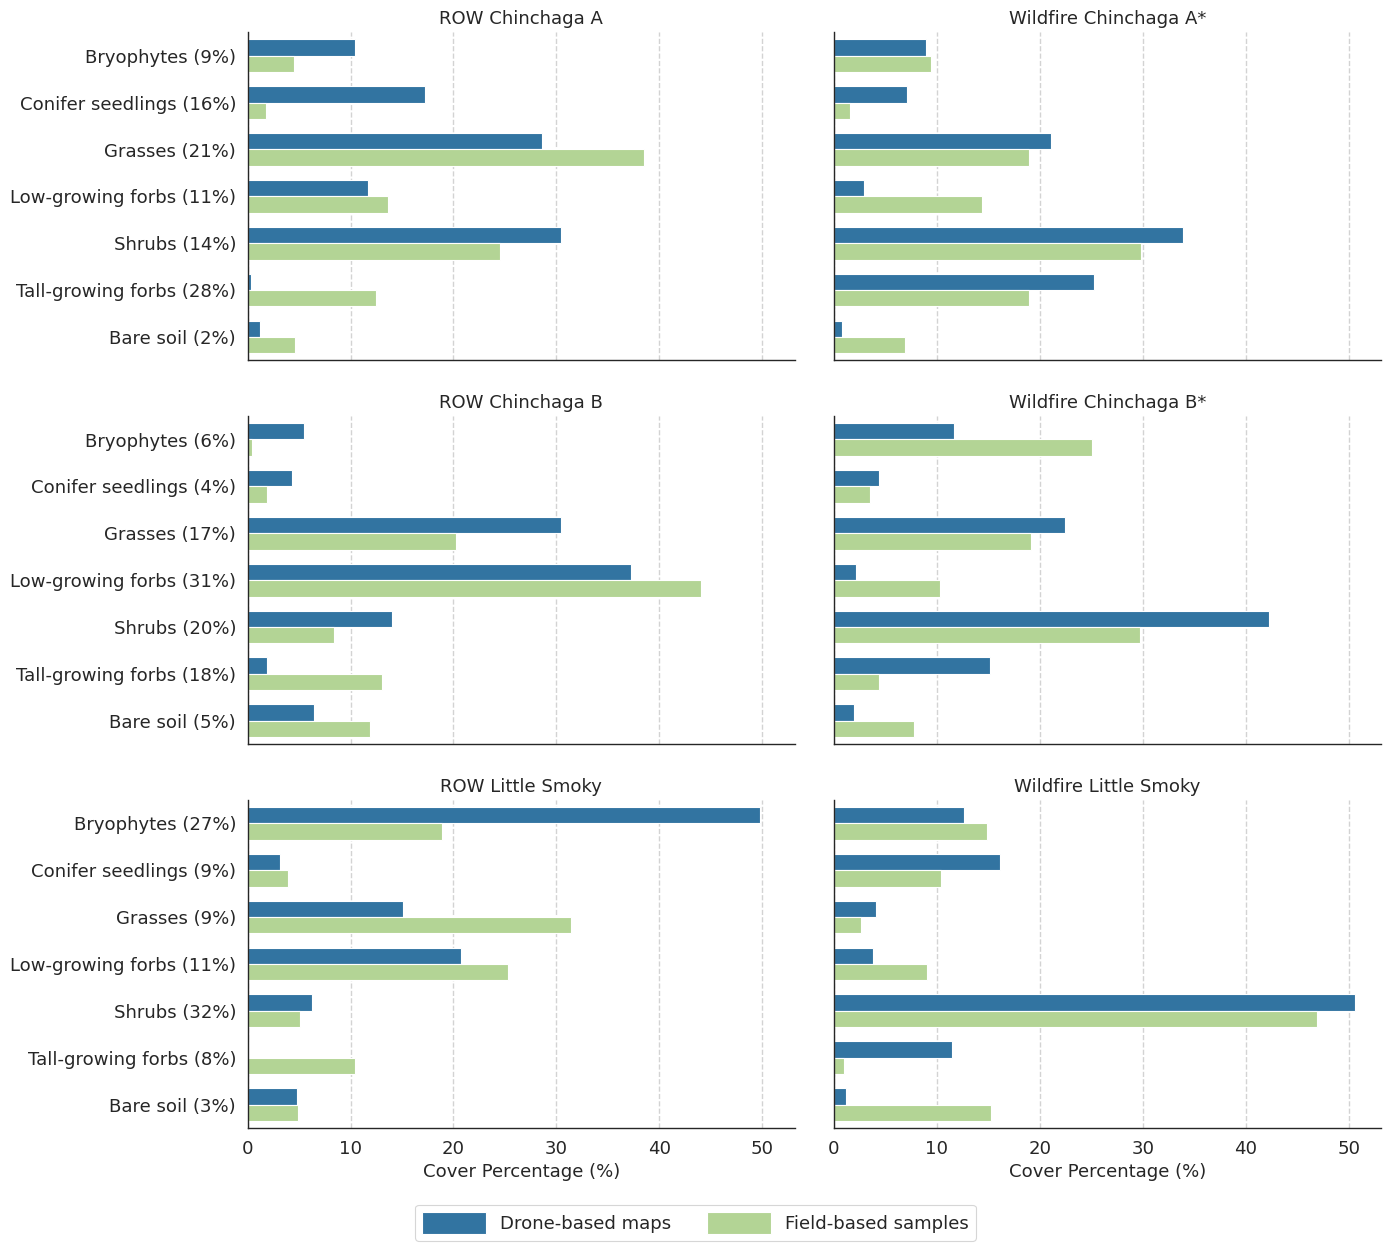

In [11]:
font_size = 13
bar_width = 0.7

# create map axis object
sns.set_style('white')
sns.set_context("paper", font_scale = 1)
fig, axs = plt.subplots(3, 2, figsize=(14,12), sharex=True, sharey=False)

cmap = {'Drone-based maps':"#1f78b4", "Field-based samples":"#b2df8a"}

### ROW 1
sns.barplot(data=df_func_types.loc[df_func_types['Site']=='ROW Chinchaga A'], y="Plant Functional Type (SIMPER)", x='Cover', 
            hue='Dataset', palette=cmap, ax=axs[0,0], width=bar_width) # 1
axs[0,0].set_title('ROW Chinchaga A', fontsize=font_size)
sns.barplot(data=df_func_types.loc[df_func_types['Site']=='Wildfire Chinchaga A'], y="Plant Functional Type (SIMPER)", x='Cover', 
            hue='Dataset', palette=cmap, ax=axs[0,1], width=bar_width) # 2
axs[0,1].set_title('Wildfire Chinchaga A*', fontsize=font_size)
axs[0,1].set_yticks([])

### ROW 2
sns.barplot(data=df_func_types.loc[df_func_types['Site']=='ROW Chinchaga B'], y="Plant Functional Type (SIMPER)", x='Cover', 
            hue='Dataset', palette=cmap, ax=axs[1,0], width=bar_width) # 3
axs[1,0].set_title('ROW Chinchaga B', fontsize=font_size)
sns.barplot(data=df_func_types.loc[df_func_types['Site']=='Wildfire Chinchaga B'], y="Plant Functional Type (SIMPER)", x='Cover', 
            hue='Dataset', palette=cmap, ax=axs[1,1], width=bar_width) # 4
axs[1,1].set_title('Wildfire Chinchaga B*', fontsize=font_size)
axs[1,1].set_yticks([])

### ROW 3
sns.barplot(data=df_func_types.loc[df_func_types['Site']=='ROW Little Smoky'], y="Plant Functional Type (SIMPER)", x='Cover', 
            hue='Dataset', palette=cmap, ax=axs[2,0], width=bar_width) # 5
axs[2,0].set_title('ROW Little Smoky', fontsize=font_size)
sns.barplot(data=df_func_types.loc[df_func_types['Site']=='Wildfire Little Smoky'], y="Plant Functional Type (SIMPER)", x='Cover', 
            hue='Dataset', palette=cmap, ax=axs[2,1], width=bar_width) # 6
axs[2,1].set_title('Wildfire Little Smoky', fontsize=font_size)
axs[2,1].set_yticks([])

### EDIT LAYOUT
for row in axs:
    for ax in row:
        ax.set_xlabel('')
        ax.set_ylabel('')
        # Set the fontsize for x-tick labels directly 
        ax.tick_params(axis='x', labelsize=font_size)
        ax.tick_params(axis='y', labelsize=font_size)
        
        # Add vertical lines
        ax.xaxis.grid(color='lightgray', linestyle='--', linewidth=1)
        
        # Remove legend
        ax.legend().remove()

axs[2,0].set_xlabel('Cover Percentage (%)', fontsize=font_size)
axs[2,1].set_xlabel('Cover Percentage (%)', fontsize=font_size)

# Add a common legend outside the subplots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0), ncol=2, handlelength=3.5, handleheight=1.5, prop={'size':font_size})

plt.tight_layout(h_pad = 2.5, w_pad=2.5)
sns.despine()

#plt.savefig('figures/Composition_Plant_Func_Types.jpg',dpi=1200,bbox_inches='tight')

### 6. Barplots of Structure Type Composition

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


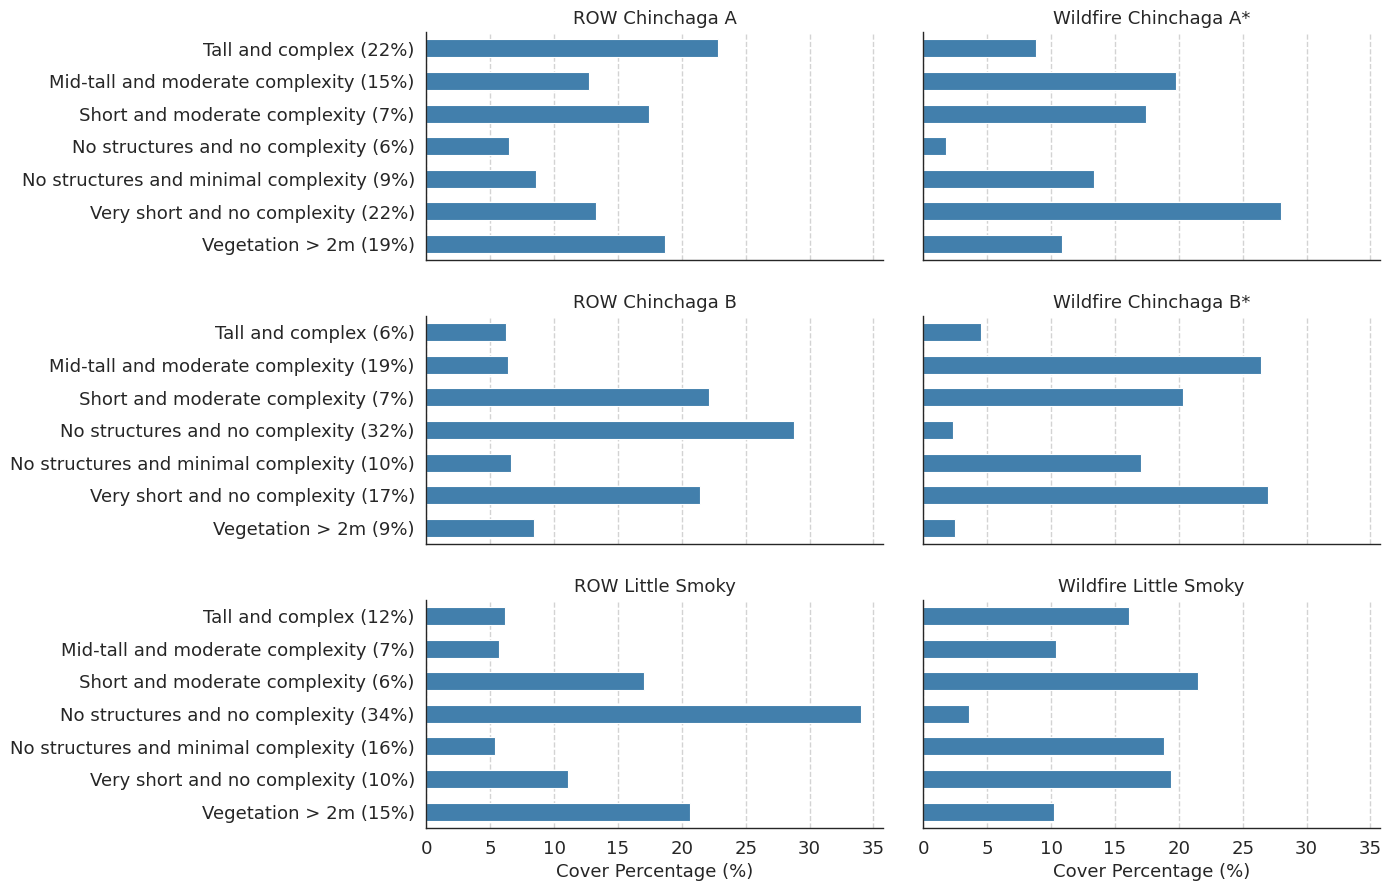

In [12]:
font_size = 13
bar_width = 0.55

# create map axis object
sns.set_style('white')
sns.set_context("paper", font_scale = 1)
fig, axs = plt.subplots(3, 2, figsize=(14,9), sharex=True, sharey=False)

cmap = {'Drone-based maps':"#1f78b4", "Field-based samples":"#b2df8a"}

### ROW 1
sns.barplot(data=df_structure.loc[df_structure['Site']=='ROW Chinchaga A'], y="Structure Type (SIMPER)", x='Cover', 
            color="#3182bd", ax=axs[0,0], width=bar_width) # 1
axs[0,0].set_title('ROW Chinchaga A', fontsize=font_size)
sns.barplot(data=df_structure.loc[df_structure['Site']=='Wildfire Chinchaga A'], y="Structure Type (SIMPER)", x='Cover', 
            color="#3182bd", ax=axs[0,1], width=bar_width) # 2
axs[0,1].set_title('Wildfire Chinchaga A*', fontsize=font_size)
axs[0,1].set_yticks([])

### ROW 2
sns.barplot(data=df_structure.loc[df_structure['Site']=='ROW Chinchaga B'], y="Structure Type (SIMPER)", x='Cover', 
            color="#3182bd", ax=axs[1,0], width=bar_width) # 3
axs[1,0].set_title('ROW Chinchaga B', fontsize=font_size)
sns.barplot(data=df_structure.loc[df_structure['Site']=='Wildfire Chinchaga B'], y="Structure Type (SIMPER)", x='Cover', 
            color="#3182bd", ax=axs[1,1], width=bar_width) # 4
axs[1,1].set_title('Wildfire Chinchaga B*', fontsize=font_size)
axs[1,1].set_yticks([])

### ROW 3
sns.barplot(data=df_structure.loc[df_structure['Site']=='ROW Little Smoky'], y="Structure Type (SIMPER)", x='Cover', 
            color="#3182bd", ax=axs[2,0], width=bar_width) # 5
axs[2,0].set_title('ROW Little Smoky', fontsize=font_size)
sns.barplot(data=df_structure.loc[df_structure['Site']=='Wildfire Little Smoky'], y="Structure Type (SIMPER)", x='Cover', 
            color="#3182bd", ax=axs[2,1], width=bar_width) # 6
axs[2,1].set_title('Wildfire Little Smoky', fontsize=font_size)
axs[2,1].set_yticks([])

### EDIT LAYOUT
for row in axs:
    for ax in row:
        ax.set_xlabel('')
        ax.set_ylabel('')
        # Set the fontsize for x-tick labels directly 
        ax.tick_params(axis='x', labelsize=font_size)
        ax.tick_params(axis='y', labelsize=font_size)
        
        # Add vertical lines
        ax.xaxis.grid(color='lightgray', linestyle='--', linewidth=1)
        
        # Remove legend
        ax.legend().remove()

axs[2,0].set_xlabel('Cover Percentage (%)', fontsize=font_size)
axs[2,1].set_xlabel('Cover Percentage (%)', fontsize=font_size)

plt.tight_layout(h_pad = 2.5, w_pad=2.5)
sns.despine()

#plt.savefig('figures/Composition_Structure_Types.jpg',dpi=1200,bbox_inches='tight')

### 7. Calculate Average Species Richness by Site
Calculate for all species and native species

In [13]:
# Check DataFrame Beforehand
df.head()

,QuadratID,Site.Name,Transect,Grid,Cover,Species_corrected_unique,Species_latin,Feature,POSSIBLE_GENUS,FAMILY,ORDER,GROUP,CATEGORY,Plant func type,Native in Alberta,Total_quadrat_cover,Cover_corrected,Site,TransectID
0,ROW Chinchaga A_4_1,ROW Chinchaga A,4,1,105,Mosses Spp.,Bryophytes,NaN,Mosses Spp.,Mosses Spp.,Mosses Spp.,Bryophytes,Bryophytes,Bryophytes,Yes,400,26.25,ROW Chinchaga A,ROW Chinchaga A_4
1,ROW Chinchaga A_4_1,ROW Chinchaga A,4,1,85,Labrador Tea,Rhododendron Spp.,NaN,Rhododendron,Ericaceae,Ericales,Angiosperms,Shrub,Shrubs,Yes,400,21.25,ROW Chinchaga A,ROW Chinchaga A_4
2,ROW Chinchaga A_4_1,ROW Chinchaga A,4,1,40,Black spruce,Picea mariana,NaN,Picea,Pinaceae,Pinales,Gymnosperms,Gymnosperms,Conifer seedlings,Yes,400,10.0,ROW Chinchaga A,ROW Chinchaga A_4
3,ROW Chinchaga A_4_1,ROW Chinchaga A,4,1,60,Aspen,Populus tremuloides Michx.,NaN,Populus,Salicaceae,Malpighiales,Angiosperms,Tree,Shrubs,Yes,400,15.0,ROW Chinchaga A,ROW Chinchaga A_4
4,ROW Chinchaga A_4_1,ROW Chinchaga A,4,1,110,Canada Bluejoint,Calamagrostis canadensis,NaN,Calamagrostis,Poaceae,Poales,Angiosperms,Grass,Grasses,Yes,400,27.5,ROW Chinchaga A,ROW Chinchaga A_4


In [14]:
### RICHNESS STATS ALL SPECIES ###
# Average richnesss by site, all species
richness_mean_site = df.groupby(['Site', 'Transect'], as_index=False)['Species_latin'].nunique().\
    groupby('Site', as_index=False)['Species_latin'].mean().\
        rename(columns={'Species_latin':'Richness Mean (All)'})
# standard deviation richnesss by site, all species
richness_std_site = df.groupby(['Site', 'Transect'], as_index=False)['Species_latin'].nunique().\
    groupby('Site', as_index=False)['Species_latin'].std().\
        rename(columns={'Species_latin':'Richness Std (all)'})
# total species
richness_total_site = df.groupby(['Site'], as_index=False)['Species_latin'].nunique().\
    rename(columns={'Species_latin':'Richness Total (all)'})
    

### RICHNESS STATS NATIVE SPECIES ###        
# Average richnesss by site, native species
richness_mean_site_native = df.loc[df['Native in Alberta']=='Yes'].groupby(['Site', 'Transect'], as_index=False)['Species_latin'].nunique().\
    groupby('Site', as_index=False)['Species_latin'].mean().\
        rename(columns={'Species_latin':'Richness Mean (Native)'})      
# standard deviation richnesss by site, native species
richness_std_site_native = df.loc[df['Native in Alberta']=='Yes'].groupby(['Site', 'Transect'], as_index=False)['Species_latin'].nunique().\
    groupby('Site', as_index=False)['Species_latin'].std().\
        rename(columns={'Species_latin':'Richness Std (Native)'}) 
# total species
richness_total_site_native = df.loc[df['Native in Alberta']=='Yes'].groupby(['Site'], as_index=False)['Species_latin'].nunique().\
    rename(columns={'Species_latin':'Richness Total (Native)'})   

### COMBINE ###
richness_df = richness_mean_site.merge(richness_std_site, on='Site').merge(richness_total_site, on='Site').merge(richness_mean_site_native, on='Site').merge(richness_std_site_native, on='Site').merge(richness_total_site_native, on='Site')
# Round only float columns
df_floats = richness_df.select_dtypes(include='float64').round(0)
# Change type to int, and merge into previous DataFrame
richness_df[df_floats.columns] = df_floats.astype(int)
# Check
richness_df.head()

,Site,Richness Mean (All),Richness Std (all),Richness Total (all),Richness Mean (Native),Richness Std (Native),Richness Total (Native)
0,ROW Chinchaga A,17,1,26,13,0,20
1,ROW Chinchaga B,12,1,23,11,1,21
2,ROW Little Smoky,15,6,21,13,6,19
3,Wildfire Little Smoky,13,3,29,13,3,29
4,Wildfires Chinchaga,24,9,59,23,8,53


### 8. Calculate Evenness Metrics
Calculate for all species

In [17]:
veg.head()

,ID,landcover_highest,indicator_selected,no_species_rejected,proba_difference,9am_mean,noon_mean,3pm_mean,NDRE_mean,NDVI_mean,...,Vaccinium spp_proba,Picea spp_proba,Trifolium spp_proba,Asteraceae spp_proba,dataset,site,dataset_cluster_strict,dataset_cluster_alpha,geometry,site_2
0,GP_chunk1_BF-122_2x2,Shrubs,Rhododendron spp,0.0,0.116224,0.686259,0.451081,0.609970,0.292796,0.671641,...,0.709135,0.577776,0.154015,0.370177,Wildfire Little Smoky_chunk1,Wildfire Little Smoky,Wildfire Little Smoky_chunk1_3,Wildfire Little Smoky_chunk1_3,"POLYGON ((432087.439 6014720.177, 432087.439 6...",Wildfire Little Smoky
1,GP_chunk1_BG-122_2x2,Bryophytes,Bryophytes,0.0,0.000000,0.435575,0.419529,0.511040,0.232598,0.533917,...,0.480421,0.589022,0.099589,0.315439,Wildfire Little Smoky_chunk1,Wildfire Little Smoky,Wildfire Little Smoky_chunk1_3,Wildfire Little Smoky_chunk1_3,"POLYGON ((432089.439 6014720.177, 432089.439 6...",Wildfire Little Smoky
2,GP_chunk1_BH-122_2x2,Conifer seedlings,Picea spp,0.0,0.060139,0.637260,0.388825,0.414147,0.283924,0.647689,...,0.000000,0.767615,0.000000,0.000000,Wildfire Little Smoky_chunk1,Wildfire Little Smoky,Wildfire Little Smoky_chunk1_3,Wildfire Little Smoky_chunk1_3,"POLYGON ((432091.439 6014720.177, 432091.439 6...",Wildfire Little Smoky
3,GP_chunk1_BI-122_2x2,Grasses,Grasses,0.0,0.000000,0.710947,0.352986,0.438489,0.334170,0.772990,...,0.394199,0.494797,0.000000,0.524801,Wildfire Little Smoky_chunk1,Wildfire Little Smoky,Wildfire Little Smoky_chunk1_3,Wildfire Little Smoky_chunk1_3,"POLYGON ((432093.439 6014720.177, 432093.439 6...",Wildfire Little Smoky
4,GP_chunk1_BJ-122_2x2,Tall-growing forbs,Asteraceae spp,2.0,0.164832,0.585105,0.413757,0.565069,0.308081,0.698688,...,0.455324,0.454555,0.000000,0.520142,Wildfire Little Smoky_chunk1,Wildfire Little Smoky,Wildfire Little Smoky_chunk1_3,Wildfire Little Smoky_chunk1_3,"POLYGON ((432095.439 6014720.177, 432095.439 6...",Wildfire Little Smoky


In [27]:
# http://scikit-bio.org/docs/0.4.0/generated/skbio.diversity.alpha.html
# Get Shannon index and Simpson's Evenness
# # Not corrected for the number of Operational Taxonomic Units (OTUs)...
from skbio.diversity.alpha import simpson_e 

# ### FIELD-SAMPLE BASED EVENNESS: SPECIES ###
# 1. Convert GRID-based cover estimates to SITE-level cover estimates
evenness_field_spp = df.groupby(['Site', 'Species_latin'], as_index=False)['Cover_corrected'].sum().merge(df.groupby(['Site'], as_index=False)['Cover_corrected'].sum().rename(columns={'Cover_corrected':'Total_cover'}), on='Site')
evenness_field_spp['Cover'] = evenness_field_spp['Cover_corrected'] / evenness_field_spp['Total_cover'] * 100
evenness_field_spp.drop(columns=['Cover_corrected', 'Total_cover'], inplace=True)
evenness_field_spp.rename(columns={'Species_latin':'Class', 'Plant func type':'Class', 'landcover_highest':'Class', 'site':'Site'}, inplace=True)

evenness_field_spp_1 = df.groupby(['Site', 'TransectID', 'Species_latin'], as_index=False)['Cover_corrected'].sum().merge(df.groupby(['TransectID'], as_index=False)['Cover_corrected'].sum().rename(columns={'Cover_corrected':'Total_cover'}), on='TransectID')
evenness_field_spp_1['Cover'] = evenness_field_spp_1['Cover_corrected'] / evenness_field_spp_1['Total_cover'] * 100
evenness_field_spp_1.drop(columns=['Cover_corrected', 'Total_cover'], inplace=True)
evenness_field_spp_1.rename(columns={'Species_latin':'Class', 'Plant func type':'Class', 'landcover_highest':'Class', 
                                     'site':'Site', 'TransectID':'Cluster'}, inplace=True)
evenness_field_spp_1_out = evenness_field_spp_1.copy()
evenness_field_spp_1_out['Cover'] = np.log(evenness_field_spp_1_out['Cover'])
evenness_field_spp_1_out.pivot(index=['Cluster', 'Site'], columns='Class', values='Cover').fillna(0).to_csv('data/Abun_field_spp.csv')

# ### FIELD-SAMPLE BASED EVENNESS: PLANT FUNCTIONAL TYPES ###
# 1. Convert GRID-based cover estimates to SITE-level cover estimates
evenness_field_functype = df.groupby(['Site', 'Plant func type'], as_index=False)['Cover_corrected'].sum().merge(df.groupby(['Site'], as_index=False)['Cover_corrected'].sum().rename(columns={'Cover_corrected':'Total_cover'}), on='Site')
evenness_field_functype['Cover'] = evenness_field_functype['Cover_corrected'] / evenness_field_functype['Total_cover'] * 100
evenness_field_functype.drop(columns=['Cover_corrected', 'Total_cover'], inplace=True)
evenness_field_functype.rename(columns={'Species_latin':'Class', 'Plant func type':'Class', 'landcover_highest':'Class', 'site':'Site'}, inplace=True)

evenness_field_functype_1 = df.groupby(['Site', 'TransectID', 'Plant func type'], as_index=False)['Cover_corrected'].sum().merge(df.groupby(['TransectID'], as_index=False)['Cover_corrected'].sum().rename(columns={'Cover_corrected':'Total_cover'}), on='TransectID')
evenness_field_functype_1['Cover'] = evenness_field_functype_1['Cover_corrected'] / evenness_field_functype_1['Total_cover'] * 100
evenness_field_functype_1.drop(columns=['Cover_corrected', 'Total_cover'], inplace=True)
evenness_field_functype_1.rename(columns={'Species_latin':'Class', 'Plant func type':'Class', 'landcover_highest':'Class', 
                                          'site':'Site', 'TransectID':'Cluster'}, inplace=True)
evenness_field_functype_1.pivot(index=['Cluster', 'Site'], columns='Class', values='Cover').fillna(0).to_csv('data/Abun_field_functype.csv')

# ### DRONE-MAP BASED EVENNESS: PLANT FUNCTIONAL TYPES ###
evenness_drone_functype = veg.groupby(['site', 'landcover_highest'], as_index=False)['ID'].count().merge(veg.groupby(['site'], as_index=False)['ID'].count().rename(columns={'ID':'Total_cover'}), on='site')
evenness_drone_functype['Cover'] = evenness_drone_functype['ID'] / evenness_drone_functype['Total_cover'] * 100
evenness_drone_functype.drop(columns=['ID', 'Total_cover'], inplace=True)
evenness_drone_functype.rename(columns={'Species_latin':'Class', 'Plant func type':'Class', 'landcover_highest':'Class', 'site':'Site'}, inplace=True)

evenness_drone_functype_1 = veg.groupby(['site', 'dataset_cluster_alpha', 'landcover_highest'], as_index=False)['ID'].count().merge(veg.groupby(['dataset_cluster_alpha'], as_index=False)['ID'].count().rename(columns={'ID':'Total_cover'}), on='dataset_cluster_alpha')
evenness_drone_functype_1['Cover'] = evenness_drone_functype_1['ID'] / evenness_drone_functype_1['Total_cover'] * 100
evenness_drone_functype_1.drop(columns=['ID', 'Total_cover'], inplace=True)
evenness_drone_functype_1.rename(columns={'Species_latin':'Class', 'Plant func type':'Class', 'landcover_highest':'Class', 
                                          'site':'Site', 'dataset_cluster_alpha':'Cluster'}, inplace=True)
evenness_drone_functype_1.pivot(index=['Cluster', 'Site'], columns='Class', values='Cover').fillna(0).to_csv('data/Abun_drone_functype.csv')



# ### DRONE-MAP BASED EVENNESS: STRUCTURE TYPES ###
evenness_drone_struc = struc.groupby(['Class', 'site'], as_index=False)['ID'].count().merge(struc.groupby(['site'], as_index=False)['ID'].count().rename(columns={'ID':'Total_cover'}), on='site')
evenness_drone_struc['Cover'] = evenness_drone_struc['ID'] / evenness_drone_struc['Total_cover'] * 100
evenness_drone_struc.drop(columns=['ID', 'Total_cover'], inplace=True)
evenness_drone_struc.rename(columns={'Species_latin':'Class', 'Plant func type':'Class', 'landcover_highest':'Class', 
                                       'site':'Site'}, inplace=True)

evenness_drone_struc_1 = struc.groupby(['Class', 'dataset_cluster_alpha', 'site'], as_index=False)['ID'].count().merge(struc.groupby(['dataset_cluster_alpha'], as_index=False)['ID'].count().rename(columns={'ID':'Total_cover'}), on='dataset_cluster_alpha')
evenness_drone_struc_1['Cover'] = evenness_drone_struc_1['ID'] / evenness_drone_struc_1['Total_cover'] * 100
evenness_drone_struc_1.drop(columns=['ID', 'Total_cover'], inplace=True)
evenness_drone_struc_1.rename(columns={'Species_latin':'Class', 'Plant func type':'Class', 'landcover_highest':'Class', 
                                       'site':'Site', 'dataset_cluster_alpha':'Cluster'}, inplace=True)
evenness_drone_struc_1.pivot(index=['Cluster', 'Site'], columns='Class', values='Cover').fillna(0).to_csv('data/Abund_drone_struc.csv')



In [28]:
# Assuming evenness_field_spp_1 is your DataFrame and simpson_e is a function defined elsewhere

# Define a custom function to apply Simpson's Evenness calculation
def calculate_simpson_e(group):
    return(simpson_e(group['Cover']))

# Group by 'Cluster' and apply the custom function to each group
simps_1 = evenness_field_spp_1.groupby(['Cluster','Site'], as_index=False).apply(calculate_simpson_e).groupby('Site').mean().rename(columns={None:'Evenness_average_field_spp'}).round(2)
simps_2 = evenness_field_spp.groupby(['Site'], as_index=False).apply(calculate_simpson_e).rename(columns={None:'Evenness_overall_field_spp'}).round(2)

simps_3 = evenness_field_functype_1.groupby(['Cluster','Site'], as_index=False).apply(calculate_simpson_e).groupby('Site').mean().rename(columns={None:'Evenness_average_field_functype'}).round(2)
simps_4 = evenness_field_functype.groupby(['Site'], as_index=False).apply(calculate_simpson_e).rename(columns={None:'Evenness_overall_field_functype'}).round(2)

simps_5 = evenness_drone_functype_1.groupby(['Cluster','Site'], as_index=False).apply(calculate_simpson_e).groupby('Site').mean().rename(columns={None:'Evenness_averge_drone_functype'}).round(2)
simps_6 = evenness_drone_functype.groupby(['Site'], as_index=False).apply(calculate_simpson_e).rename(columns={None:'Evenness_overall_drone_functype'}).round(2)

simps_7 = evenness_drone_struc_1.groupby(['Cluster','Site'], as_index=False).apply(calculate_simpson_e).groupby('Site').mean().rename(columns={None:'Evenness_average_drone_structure'}).round(2)
simps_8 = evenness_drone_struc.groupby(['Site'], as_index=False).apply(calculate_simpson_e).rename(columns={None:'Evenness_overall_drone_structure'}).round(2)

# Print the results
simps_df = simps_1.merge(simps_2, on='Site').merge(simps_3, on='Site').merge(simps_4, on='Site').merge(simps_5, on='Site').merge(simps_6, on='Site').merge(simps_7, on='Site').merge(simps_8, on='Site')
simps_df.T

/tmp/ipykernel_25455/2810688235.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  simps_1 = evenness_field_spp_1.groupby(['Cluster','Site'], as_index=False).apply(calculate_simpson_e).groupby('Site').mean().rename(columns={None:'Evenness_average_field_spp'}).round(2)
/tmp/ipykernel_25455/2810688235.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  simps_3 = evenness_field_functype_1.groupby(['Cluster','Site'], as_index=False).apply(calculate_simpson_e).groupby('Site').mean().rename(columns={None:'Evenness_average_field_functype'}).round(2)
/tmp/ipykernel_25455/2810688235.py:14: FutureWarning: The defau

,0,1,2,3,4
Site,ROW Chinchaga A,ROW Chinchaga B,ROW Little Smoky,Wildfire Little Smoky,Wildfires Chinchaga
Evenness_average_field_spp,0.34,0.28,0.45,0.45,0.36
Evenness_overall_field_spp,0.3,0.16,0.41,0.29,0.24
Evenness_average_field_functype,0.59,0.59,0.66,0.5,0.64
Evenness_overall_field_functype,0.58,0.52,0.66,0.5,0.75
Evenness_averge_drone_functype,0.62,0.5,0.48,0.44,0.48
Evenness_overall_drone_functype,0.62,0.55,0.45,0.45,0.59
Evenness_average_drone_structure,0.82,0.65,0.65,0.79,0.63
Evenness_overall_drone_structure,0.88,0.73,0.68,0.85,0.75


### 9. Calculate ANOSIM Metrics
R- and p-values

In [29]:
from skbio import DistanceMatrix
from skbio.stats.distance import anosim

# ### FIELD-SAMPLE BASED EVENNESS: SPECIES ###
# 1. Convert GRID-based cover estimates to SITE-level cover estimates
matrix_field_spp = df.groupby(['TransectID', 'Species_latin'], as_index=False)['Cover_corrected'].sum().\
    merge(df.groupby(['TransectID'], as_index=False)['Cover_corrected'].sum().rename(columns={'Cover_corrected':'Total_cover'}), on='TransectID')
matrix_field_spp['Cover'] = matrix_field_spp['Cover_corrected'] / matrix_field_spp['Total_cover'] * 100
matrix_field_spp['Cover'] = np.log(matrix_field_spp['Cover'])
matrix_field_spp = matrix_field_spp.pivot(index='TransectID', columns='Species_latin', values='Cover').fillna(0)

# ### FIELD-SAMPLE BASED EVENNESS: PLANT FUNCTIONAL TYPES ###
# 1. Convert GRID-based cover estimates to SITE-level cover estimates
matrix_field_functype = df.groupby(['TransectID', 'Plant func type'], as_index=False)['Cover_corrected'].sum().\
    merge(df.groupby(['TransectID'], as_index=False)['Cover_corrected'].sum().rename(columns={'Cover_corrected':'Total_cover'}), on='TransectID')
matrix_field_functype['Cover'] = matrix_field_functype['Cover_corrected'] / matrix_field_functype['Total_cover'] * 100
matrix_field_functype = matrix_field_functype.pivot(index='TransectID', columns='Plant func type', values='Cover').fillna(0)

# ### DRONE-MAP BASED EVENNESS: PLANT FUNCTIONAL TYPES ###
matrix_drone_functype = veg.groupby(['dataset_cluster_alpha', 'landcover_highest'], as_index=False)['ID'].count().\
    merge(veg.groupby(['dataset_cluster_alpha'], as_index=False)['ID'].count().rename(columns={'ID':'Total_cover'}), on='dataset_cluster_alpha')
matrix_drone_functype['Cover'] = matrix_drone_functype['ID'] / matrix_drone_functype['Total_cover'] * 100
matrix_drone_functype = matrix_drone_functype.pivot(index='dataset_cluster_alpha', columns='landcover_highest', values='Cover').fillna(0)

# # ### DRONE-MAP BASED EVENNESS: STRUCTURE TYPES ###
matrix_drone_struc = struc.groupby(['dataset_cluster_alpha', 'Class'], as_index=False)['ID'].count().\
    merge(struc.groupby(['dataset_cluster_alpha'], as_index=False)['ID'].count().rename(columns={'ID':'Total_cover'}), on='dataset_cluster_alpha')
matrix_drone_struc['Cover'] = matrix_drone_struc['ID'] / matrix_drone_struc['Total_cover'] * 100
matrix_drone_struc = matrix_drone_struc.pivot(index='dataset_cluster_alpha', columns='Class', values='Cover').fillna(0)

In [30]:
# Create empty DataFrame for AnoSim outputs
anosim_df = pd.DataFrame({'Site_a':[], 'Site_b':[], 'Dataset':[], 'sample_size':[],'R_value':[], 'p_value':[]})

# Loop through site pairs
for df_i in [(matrix_field_spp, 'Field_Spp'), (matrix_field_functype, 'Field_FuncType'), 
           (matrix_drone_functype, 'Drone_FuncType'), (matrix_drone_struc, 'Drone_Structure')]:
        for i,j in [('ROW Chinchaga A', 'Wildfires Chinchaga'),
                ('ROW Chinchaga B', 'Wildfires Chinchaga'),
                ('ROW Little Smoky', 'Wildfire Little Smoky')]:
                # Select site pairs from abundance matrix (rows:sites, columns:species/plant types)
                select = df_i[0].loc[(df_i[0].index.str.contains(i))|(df_i[0].index.str.contains(j))]
                # Create DistanceMatrix with Bray-Curtis
                matrix = DistanceMatrix(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(select, 'braycurtis')), select.index)
                # Calculate Anosim for Site pair
                anosim_out = anosim(matrix, [i.split('_')[0] for i in select.index.tolist()], permutations=9999)
                # Append output as new row to the 'anosim_df' DataFrame
                anosim_df = anosim_df.append({'Site_a': i, 'Site_b': j, 'Dataset':df_i[1], 'sample_size': anosim_out['sample size'],
                                                'R_value': anosim_out['test statistic'].round(2), 'p_value': anosim_out['p-value'].round(5)}, ignore_index=True)

/tmp/ipykernel_25455/2561876700.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anosim_df = anosim_df.append({'Site_a': i, 'Site_b': j, 'Dataset':df_i[1], 'sample_size': anosim_out['sample size'],
/tmp/ipykernel_25455/2561876700.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anosim_df = anosim_df.append({'Site_a': i, 'Site_b': j, 'Dataset':df_i[1], 'sample_size': anosim_out['sample size'],
/tmp/ipykernel_25455/2561876700.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  anosim_df = anosim_df.append({'Site_a': i, 'Site_b': j, 'Dataset':df_i[1], 'sample_size': anosim_out['sample size'],
/tmp/ipykernel_25455/2561876700.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in 

In [31]:
anosim_df


,Site_a,Site_b,Dataset,sample_size,R_value,p_value
0,ROW Chinchaga A,Wildfires Chinchaga,Field_Spp,8.0,0.93,0.0380
1,ROW Chinchaga B,Wildfires Chinchaga,Field_Spp,9.0,0.90,0.0132
2,ROW Little Smoky,Wildfire Little Smoky,Field_Spp,9.0,0.98,0.0264
3,ROW Chinchaga A,Wildfires Chinchaga,Field_FuncType,8.0,-0.14,0.6374
4,ROW Chinchaga B,Wildfires Chinchaga,Field_FuncType,9.0,0.64,0.0097
5,ROW Little Smoky,Wildfire Little Smoky,Field_FuncType,9.0,0.81,0.0267
6,ROW Chinchaga A,Wildfires Chinchaga,Drone_FuncType,70.0,0.03,0.2530
7,ROW Chinchaga B,Wildfires Chinchaga,Drone_FuncType,89.0,0.44,0.0001
8,ROW Little Smoky,Wildfire Little Smoky,Drone_FuncType,37.0,1.00,0.0001
9,ROW Chinchaga A,Wildfires Chinchaga,Drone_Structure,70.0,0.16,0.0030
